In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
import sys
from os.path import join

sys.path.insert(0, '/'.join(sys.path[0].split('/')[:-1] + ['scripts']))
from stats_logging import *

In [3]:
#export
from functools import partial

def annealer(fn):
    return lambda start, end: partial(fn, start, end)

@annealer
def schedule_lin(start, end, position):
    return start + position * (end - start)

@annealer
def schedule_cos(start, end, position):
    return start + (1+math.cos(math.pi*(1-position))) * (end-start)/2

@annealer
def schedule_none(start, end, position):
    return start

@annealer
def schedule_exp(start, end, position):
    return start * (end/start)**position

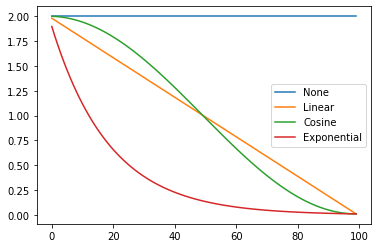

In [4]:
schedulings = [schedule_none, schedule_lin, schedule_cos, schedule_exp]
names = "None Linear Cosine Exponential".split()
a = torch.arange(0, 100)
p = torch.linspace(0.01, 1, 100)
for fn, name in zip(schedulings, names):
    f = fn(2, 1e-2)
    plt.plot(a, [f(n) for n in p], label=name)
plt.legend()

In [5]:
#export
def combine_schedules(segments, ranges):
    assert(sum(segments) == 1.)
    segments = tensor([0] + segments)
    assert(torch.all(segments >= 0))
    segments = torch.cumsum(segments, 0)
    
    def inner(pos):
        i = (pos >= segments).nonzero().max()
        actual_pos = (pos - segments[i]) / (segments[i+1] - segments[i])
        return ranges[i](actual_pos)
    return inner

def plot_schedules(schedule):
    a = torch.arange(0, 100)
    p = torch.linspace(0.01, 1, 100)
    plt.plot(a, [schedule(n) for n in p])

In [6]:
#export
def one_cycle_cos(start, upper, end):
    return [schedule_cos(start, upper), schedule_cos(upper, end)]

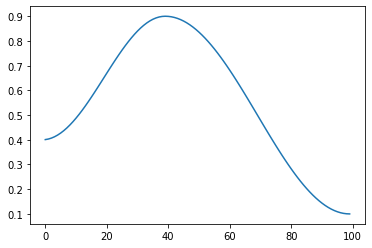

In [7]:
segments = [0.4, 0.6]
ranges = one_cycle_cos(0.4, 0.9, 0.1)
schedule = combine_schedules(segments, ranges)
plot_schedules(schedule)

In [8]:
#export
class Optimizer():
    def __init__(self, parameters, **hyper_params):
        self.parameters = parameters
        self.hyper_params = dict(hyper_params)
    
    def __repr__(self):
        return f'(Optimizer) num_params: {len(self.parameters)}, hyper_params: {list(self.hyper_params)}'
        
    def step(self):
        for parameter in self.parameters:
            parameter.step(self.hyper_params['learning_rate'])
    
    def zero_grad(self):
        for parameter in self.parameters:
            parameter.zero_grad()
    
def get_model(data_bunch, learning_rate=0.1, num_hidden=50):
    in_dim = data_bunch.train_ds.x_data.shape[1]
    out_dim = int(max(data_bunch.train_ds.y_data) + 1)
    model = Sequential(Linear(in_dim, num_hidden), ReLU(), Linear(num_hidden, out_dim, end=True))
    return model, Optimizer(list(model.parameters()), learning_rate=learning_rate)

In [9]:
#export
class Recorder(Callback):
    def __init__(self, param_names):
        self.parameters = {name: [] for name in param_names}
        
    def before_fit(self):
        self.losses = []
        
    def after_batch(self): 
        if not self.model.training: return
        self.losses.append(self.loss)
        for name in self.parameters:
            self.parameters[name].append(self.optimizer.hyper_params[name])       

    def plot_losses(self): 
        plt.plot(self.losses)
        plt.ylabel('loss')
        plt.xlabel('batch')
    
    def plot_parameter(self, name):
        plt.plot(self.parameters[name])
        plt.ylabel(' '.join(name.split('_')))
        plt.xlabel('batch')

class ParamScheduler(Callback):
    def __init__(self, param_name, schedule_fn): 
        self.param_name = param_name
        self.schedule_fn = schedule_fn
        
    def set_param(self):
        self.optimizer.hyper_params[self.param_name] = self.schedule_fn(self.iters_count / self.iters)
            
    def before_batch(self): 
        if self.model.training:
            self.set_param()

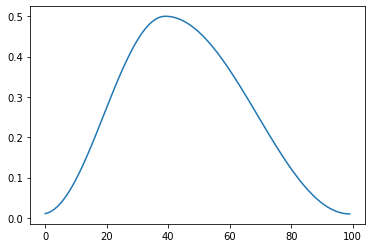

In [10]:
schedule = combine_schedules([0.4, 0.6], one_cycle_cos(0.01, 0.5, 0.01))
plot_schedules(schedule)

In [11]:
num_hidden = 50
batch_size = 64
num_epochs = 20
learning_rate = 0.1

data_bunch = get_data_bunch(*get_mnist_data(), batch_size)
model, optimizer = get_model(data_bunch, learning_rate, num_hidden)
loss_fn = CrossEntropy()
learner = Learner(model, optimizer, loss_fn, data_bunch)

runner = Runner(learner, [ParamScheduler('learning_rate', schedule), Recorder(['learning_rate']), StatsLogging([compute_accuracy])])
print(runner)

(DataBunch) 
	(DataLoader) 
		(Dataset) x: (50000, 784), y: (50000,)
		(Sampler) total: 50000, batch_size: 64, shuffle: True
	(DataLoader) 
		(Dataset) x: (10000, 784), y: (10000,)
		(Sampler) total: 10000, batch_size: 128, shuffle: False
(Sequential)
	(Layer1) Linear(784, 50)
	(Layer2) ReLU()
	(Layer3) Linear(50, 10)
(CrossEntropy)
(Optimizer) num_params: 4, hyper_params: ['learning_rate']
(Callbacks) TrainEval ParamScheduler Recorder StatsLogging


In [12]:
runner.fit(5)

Epoch - 1
train metrics - [1.3822174072265625e-06, 0.88816]
valid metrics - [5.2094125747680667e-05, 0.9625]

Epoch - 2
train metrics - [1.562652587890625e-06, 0.95492]
valid metrics - [6.627321243286133e-06, 0.9665]

Epoch - 3
train metrics - [4.1743688583374026e-05, 0.96456]
valid metrics - [5.835342407226563e-06, 0.9721]

Epoch - 4
train metrics - [5.896339416503906e-05, 0.96998]
valid metrics - [1.8055915832519531e-06, 0.9698]

Epoch - 5
train metrics - [1.7911109924316406e-05, 0.9733]
valid metrics - [1.0947227478027343e-06, 0.9709]



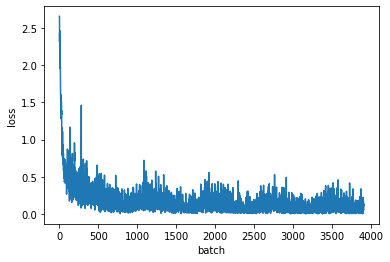

In [13]:
runner.callbacks[2].plot_losses()

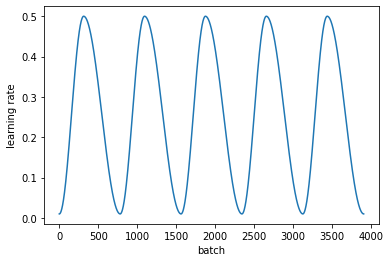

In [14]:
runner.callbacks[2].plot_parameter('learning_rate')